In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py as hd

fn =  '../data/anomaly.h5'
N = 10000
p = 700

In [2]:
df = pd.read_hdf(fn,stop=N)
print(df.shape)
print("Memory in GB:",sum(df.memory_usage(deep=True)) / (1024**3))

FileNotFoundError: File ../data/anomaly.h5 does not exist

In [3]:
y = df.iloc[:, -1].values
X = df.iloc[:,:-1].values
X = np.reshape(X, (N, p, 3))
Bs, Ss = [], []
for arr,events in [(Bs, X[y==0]), (Ss, X[y==1])]:
    for i,x in enumerate(events):
        # ignore padded particles and removed particle id information
        x = x[x[:,0] != 0]

        # center jet according to pt-centroid
        yphi_avg = np.average(x[:,1:3], weights=x[:,0], axis=0)
        x[:,1:3] -= yphi_avg

        # mask out any particles farther than R=0.4 away from center (rare)
        # add to list
        x = sorted(x, key=lambda a: a[0], reverse=True)
        x = np.array(x[:100])
        arr.append(x)


Using TensorFlow backend.


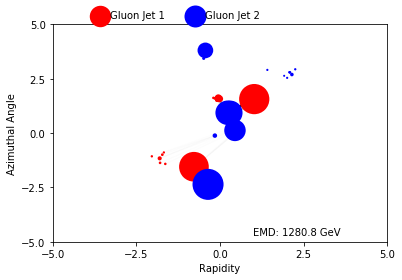

In [4]:
# choose interesting events
from energyflow.emd import emd, emds
import matplotlib.pyplot as plt

ev0, ev1 = Ss[0], Ss[15]

# calculate the EMD and the optimal transport flow
R = 5
emdval, B = emd(ev0, ev1, R=R, return_flow=True)

# plot the two events
colors = ['red', 'blue']
labels = ['Gluon Jet 1', 'Gluon Jet 2']
for i,ev in enumerate([ev0, ev1]):
    pts, ys, phis = ev[:,0], ev[:,1], ev[:,2]
    plt.scatter(ys, phis, marker='o', s=2*pts, color=colors[i], lw=0, zorder=10, label=labels[i])
    
# plot the flow
mx = B.max()
xs, xt = ev0[:,1:3], ev1[:,1:3]
for i in range(xs.shape[0]):
    for j in range(xt.shape[0]):
        if B[i, j] > 0:
            plt.plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]],
                     alpha=B[i, j]/mx, lw=1.25, color='black')

# plot settings
plt.xlim(-R, R); plt.ylim(-R, R)
plt.xlabel('Rapidity'); plt.ylabel('Azimuthal Angle')
plt.xticks(np.linspace(-R, R, 5)); plt.yticks(np.linspace(-R, R, 5))

plt.text(0.6, 0.03, 'EMD: {:.1f} GeV'.format(emdval), fontsize=10, transform=plt.gca().transAxes)
plt.legend(loc=(0.1, 1.0), frameon=False, ncol=2, handletextpad=0)

plt.show()

In [5]:
data = Bs + Ss
emds = emds(data, R=R, norm=True, verbose=1, n_jobs=1, print_every=10000)

Computed 0 EMDs, 0.00% done in 0.00s


KeyboardInterrupt: 

### Model Stuff

In [43]:
# import the knn graph and partitions
G = nx.read_gpickle('pickles/knn_graph.gpickle')
partitions = nx.read_gpickle('pickles/graph_partitions.pickle')

N = len(G.nodes())
M = len(partitions)
levels = int(np.log2(M))

In [6]:
# load the training data
points = pickle.load(open('pickles/points.pickle', 'rb'))
assert len(points) == N

In [47]:
import networkx as nx
import pickle
import numpy as np

def get_flat_X_unsorted():
    # flatten each training point's feature matrix into a single feature vector
    # note that not every collision event may have the same number of particles
    num_particles = 0
    for point in points:
        num_particles = max(num_particles, point.shape[0])
    num_readings = points[0].shape[1] # every particle should have the same number (3) of readigns

    X = []
    for point in points:
        feature = np.copy(point)
        feature.resize((num_particles * num_readings, ))
        X.append(feature)
    return np.array(X)

def get_flat_X_sorted():
    # flatten each training point's feature matrix into a single feature vector
    # note that not every collision event may have the same number of particles
    num_particles = 0
    for point in points:
        num_particles = max(num_particles, point.shape[0])
    num_readings = points[0].shape[1] # every particle should have the same number (3) of readigns

    X = []
    for point in points:
        feature = np.copy(point)
        
        # sort the point data by the first column
        index = feature[:,0].argsort()
        feature = feature[index]
        
        # now flatten the feature and fill in with 0's
        feature.resize((num_particles * num_readings, ))
        X.append(feature)
    return np.array(X)

def get_class_labels():
    # create labels for each node
    labels_dict = {}
    for i, part in enumerate(partitions):
        for node in part:
            labels_dict[node] = i
    
    labels = []
    for i in range(N):
        labels.append(labels_dict[i])
    return np.array(labels)

def get_hierarchical_labels():
    # return vector of 0 and 1's where each entry determines next splitting point
    labels = get_class_labels()
    
    Y = []
    for label in labels:
        hierarchical_label = []
        for j in range(levels):
            hierarchical_label.append(label // (2 ** (levels - 1 - j)))
            label = label % (2 ** (levels - 1 - j))
        Y.append(hierarchical_label)
    return np.array(Y)

def get_soft_labels():
    # first get regular labels
    labels = get_class_labels()

    # turn the labels into soft labels
    # for this, the label becomes the empirical distribution of the part that each node's S nearest neighbors belong to
    nns = nx.read_gpickle('pickles/nearest_neighbors.pickle')
    Y = []
    for i in range(N):
        distribution = np.zeros(M)
        for n in nns[i]:
            distribution[labels[n]] += 1
        distribution = np.divide(distribution, np.sum(distribution))
        Y.append(distribution)
    Y = np.array(Y)

    return Y

### Hierarchical Logistic Regression (Naive)

In [112]:
from sklearn.linear_model import LogisticRegression

def lr_train_hierarchical(models, prefix, X, y, level):
    if level == levels:
        return
    
    clf = LogisticRegression().fit(X, y[:,level])
    models[prefix] = clf
    
    predictions = clf.predict(X)
    
    all_zeros = np.ones(len(predictions))
    X_left = X[predictions == all_zeros]
    y_left = y[predictions == all_zeros]
    lr_train_hierarchical(models, prefix + '0', X_left, y_left, level + 1)
    
    all_ones = np.ones(len(predictions))
    X_right = X[predictions == all_ones]
    y_right = y[predictions == all_ones]
    lr_train_hierarchical(models, prefix + '1', X_right, y_right, level + 1)
    
def lr_prediction_accuracy(X, y):
    num_levels = levels # how deep in the tree to check
    num_correct = 0
    
    # check each data point
    for i in range(len(X)):
        x = X[i:i+1,:]
        prefix = ""
        
        prediction = []
        while len(prefix) < num_levels:
            clf = models[prefix]
            label = clf.predict(x)[0]
            prefix += str(label)
            prediction.append(label)
        prediction = np.array(prediction)
                
        if (y[i][:num_levels] == prediction).all():
            num_correct += 1
    
    return num_correct / len(X)

In [113]:
from sklearn.model_selection import train_test_split

X = get_flat_X_sorted()
y = get_hierarchical_labels()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train the top_level_model
models = {}
lr_train_hierarchical(models, "", X_train, y_train, 0)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureW

In [114]:
# now assess test accuracy
print(lr_prediction_accuracy(X_test, y_test))

0.075


In [122]:
# Try with just 1 level
X = get_flat_X_sorted()
y = get_hierarchical_labels()[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = LogisticRegression().fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(np.sum(y_test == y_pred) / len(X_test))

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.505


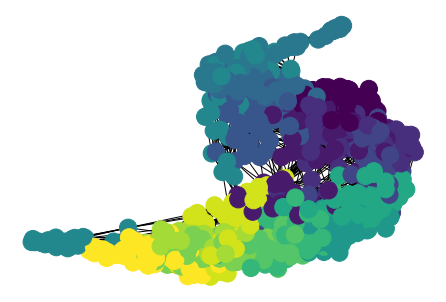

In [121]:
import matplotlib.pyplot as plt

labels = get_class_labels()

nx.draw(G, node_color = labels)
plt.show()

### Neural Network

In [4]:
# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import EFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, to_categorical

# attempt to import sklearn
try:
    from sklearn.metrics import roc_auc_score, roc_curve
except:
    print('please install scikit-learn in order to make ROC curves')
    roc_curve = False

# attempt to import matplotlib
try:
    import matplotlib.pyplot as plt
except:
    print('please install matploltib in order to make plots')
    plt = False

################################### SETTINGS ##################################
# the commented values correspond to those in 1810.05165
###############################################################################
# data controls, can go up to 2000000 total for full dataset
train, val, test = 750, 50, 200
# train, val, test = 1000000, 200000, 200000

# network architecture parameters
#Phi_sizes, F_sizes = (100, 100, 16), (10, 10, 10)
Phi_sizes, F_sizes = (10, 10, 16), (10, 10, 10)

# network training parameters
num_epoch = 10
batch_size = 50

###############################################################################
print('Finished preprocessing')
# do train/val/test split 
(z_train, z_val, z_test, 
 p_train, p_val, p_test,
 Y_train, Y_val, Y_test) = data_split(X[:,:,0], X[:,:,1:], y, val=val, test=test)

print('Done train/val/test split')
print('Model summary:')

# build architecture
efn = EFN(input_dim=2, output_dim=16, Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# train model
efn.fit([z_train, p_train], Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=([z_val, p_val], Y_val),
          verbose=1)

# get predictions on test data
preds = efn.predict([z_test, p_test], batch_size=200)

Using TensorFlow backend.


Finished preprocessing
Done train/val/test split
Model summary:
Instructions for updating:
Colocations handled automatically by placer.


ValueError: Can not perform batch_dot over axis 0.If your inputs are not batched, add a dummy batch dimension to your inputs using K.expand_dims(x, 0)

### K-Means (Benchmark)